<a href="https://colab.research.google.com/github/jiyoungemma/section2_project/blob/main/Uber_fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/uber.csv')

In [ ]:
!pip install -U pandas-profiling

In [ ]:
pip install category_encoders

In [ ]:
pip install xgboost

In [ ]:
pip install eli5

In [ ]:
pip install shap

In [ ]:
pip install pdpbox

In [ ]:
pip uninstall matplotlib

In [ ]:
pip install --upgrade matplotlib

In [ ]:
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [ ]:
df.rename(columns={'Unnamed: 0' : 'customer', 'key':'date'} ,inplace=True)

In [ ]:
df['pickup_datetime'] = df['pickup_datetime'].apply(str).apply(lambda x: x[:-3])

In [ ]:
df.drop(columns='date',inplace=True)

In [ ]:
import datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [ ]:
df.dtypes

customer                      int64
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [ ]:
df['year'] = df.pickup_datetime.dt.year
df['month'] = df.pickup_datetime.dt.month
df['weekday'] = df.pickup_datetime.dt.weekday # 0: 월, 1:화, 2:수, 3:목, 4:금, 5:토, 6:일
df['hour'] = df.pickup_datetime.dt.hour

In [ ]:
df

,customer,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour
0,24238194,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,3,19
1,27835199,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,4,20
2,44984355,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,0,21
3,25894730,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,4,8
4,17610152,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,3,17
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,42598914,3.0,2012-10-28 10:49:00,-73.987042,40.739367,-73.986525,40.740297,1,2012,10,6,10
199996,16382965,7.5,2014-03-14 01:09:00,-73.984722,40.736837,-74.006672,40.739620,1,2014,3,4,1
199997,27804658,30.9,2009-06-29 00:42:00,-73.986017,40.756487,-73.858957,40.692588,2,2009,6,0,0
199998,20259894,14.5,2015-05-20 14:56:25,-73.997124,40.725452,-73.983215,40.695415,1,2015,5,2,14


In [ ]:
df.isna().sum()

customer             0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
year                 0
month                0
weekday              0
hour                 0
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df = df[(df.pickup_latitude<90) & (df.dropoff_latitude<90) &
        (df.pickup_latitude>-90) & (df.dropoff_latitude>-90) &
        (df.pickup_longitude<180) & (df.dropoff_longitude<180) &
        (df.pickup_longitude>-180) & (df.dropoff_longitude>-180)]

In [ ]:
import geopy.distance
df['distance']=[round(geopy.distance.distance((df.pickup_latitude[i], df.pickup_longitude[i]),(df.dropoff_latitude[i], df.dropoff_longitude[i])).km,2) for i in df.index]

In [ ]:
df.head()

,customer,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,distance
0,24238194,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,3,19,1.68
1,27835199,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,4,20,2.45
2,44984355,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,0,21,5.04
3,25894730,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,4,8,1.66
4,17610152,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,3,17,4.48


In [ ]:
target = 'fare_amount'

In [ ]:
import pandas_profiling

df.profile_report()

In [ ]:
fareminus = df.loc[df['fare_amount'] < 0].index

In [ ]:
zero = df.loc[df['passenger_count'] == 0].index
two = df.loc[df['passenger_count'] == 208].index

In [ ]:
df.drop(fareminus,inplace=True)
df.drop(zero,inplace=True)
df.drop(two,inplace=True)

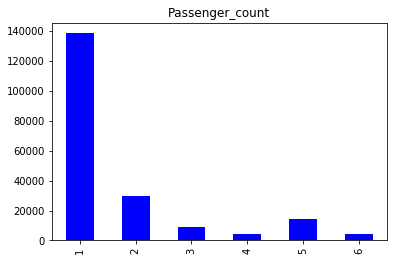

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
passenger = pd.value_counts(df['passenger_count'].values, sort=False)
passenger.plot.bar(color="b");
plt.title("Passenger_count");

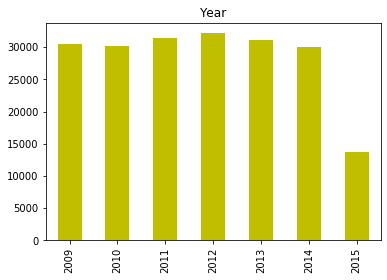

In [ ]:
year = pd.value_counts(df['year'].values, sort=False)
year.plot.bar(color="y");
plt.title("Year");

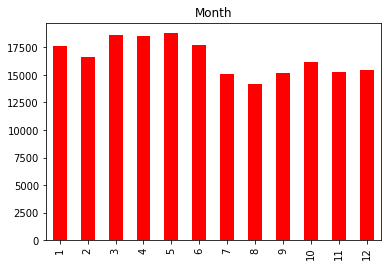

In [ ]:
month = pd.value_counts(df['month'].values, sort=False)
month.plot.bar(color="r");
plt.title("Month");

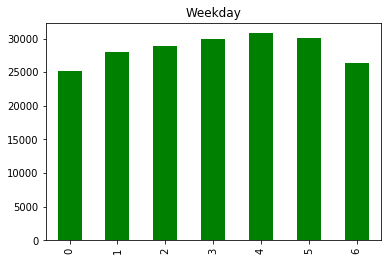

In [ ]:
weekday = pd.value_counts(df['weekday'].values, sort=False)
weekday.plot.bar(color="g");
plt.title("Weekday");

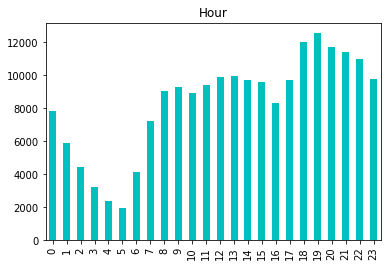

In [ ]:
hour = pd.value_counts(df['hour'].values, sort=False)
hour.plot.bar(color="c");
plt.title("Hour");

In [ ]:
no = df.loc[df['distance'] == 0].index
df.drop(no, inplace=True)

In [ ]:
df['distance'].describe()

count    193223.000000
mean         20.995578
std         383.217590
min           0.010000
25%           1.290000
50%           2.190000
75%           3.960000
max        8783.590000
Name: distance, dtype: float64

In [ ]:
df['fare_amount'].describe()

count    199261.000000
mean         11.369090
std           9.906025
min           0.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

In [ ]:
far = df.loc[df['fare_amount'] >= 100].index
df.drop(far, inplace=True)

In [ ]:
df['fare_amount'].describe()

count    199171.000000
mean         11.310112
std           9.433910
min           0.000000
25%           6.000000
50%           8.500000
75%          12.500000
max          99.200000
Name: fare_amount, dtype: float64

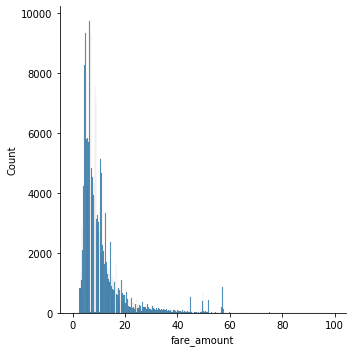

In [ ]:
target = df['fare_amount']
sns.displot(target);

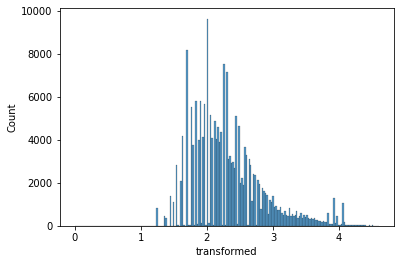

In [ ]:
import numpy as np
plots=pd.DataFrame()
plots['transformed']=np.log1p(target)
sns.histplot(plots['transformed']);

In [ ]:
df.shape

(193223, 13)

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.8, test_size=0.2, random_state=2)

train.shape, test.shape

((154578, 13), (38645, 13))

In [ ]:
target = 'fare_amount'

train, val = train_test_split(train, train_size=0.8, test_size=0.2, random_state=2)

train.shape, val.shape, test.shape

((123662, 13), (30916, 13), (38645, 13))

In [ ]:
df.columns

Index(['customer', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'year', 'month', 'weekday', 'hour', 'distance'],
      dtype='object')

In [ ]:
features = ['customer','passenger_count','year','month','weekday','hour','distance']

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [ ]:
# 선형회귀 기준모델
from pandas.util.testing import assert_frame_equal
from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

model = LinearRegression()

model.fit(X_train,y_train)
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'훈련 에러: {mae: f}')
r2 = r2_score(y_train, y_pred)
print(f'R^2:{r2: f}')

훈련 에러:  5.859428
R^2: 0.018086


In [ ]:
# 절편, 회귀계수
model.intercept_, model.coef_

(-1269.6093715266793,
 array([ 5.19796650e-10,  1.10051825e-01,  6.36457570e-01,  1.08476680e-01,
         1.41335054e-02, -3.07571434e-02,  6.41160826e-04]))

In [ ]:
b0 = model.intercept_
b1, b2, b3, b4, b5, b6, b7 = model.coef_

print(f'y = {b0:f} + {b1:.9f}x\u2081 + {b2:f}x\u2082+ {b3:f}x\u2083+ {b4:f}x\u2084+ {b5:f}x\u2085+ {b6:f}x\u2086+ {b7:.7f}x\u2087')

y = -1269.609372 + 0.000000001x₁ + 0.110052x₂+ 0.636458x₃+ 0.108477x₄+ 0.014134x₅+ -0.030757x₆+ 0.0006412x₇


In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
#gradient boosting
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val) 

boosting = XGBRegressor(
    n_estimators=1000,
    objective='reg:squarederror', 
    learning_rate=0.2,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

tt = TransformedTargetRegressor(regressor=boosting,
                                func=np.log1p, inverse_func=np.expm1)


boosting.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50
         )

[0]	validation_0-rmse:11.7246	validation_1-rmse:11.6579
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:9.72528	validation_1-rmse:9.67762
[2]	validation_0-rmse:8.17569	validation_1-rmse:8.14775
[3]	validation_0-rmse:6.99446	validation_1-rmse:6.98231
[4]	validation_0-rmse:6.11707	validation_1-rmse:6.11709
[5]	validation_0-rmse:5.46145	validation_1-rmse:5.46868
[6]	validation_0-rmse:4.9915	validation_1-rmse:5.00553
[7]	validation_0-rmse:4.65574	validation_1-rmse:4.67087
[8]	validation_0-rmse:4.42038	validation_1-rmse:4.43912
[9]	validation_0-rmse:4.25023	validation_1-rmse:4.27134
[10]	validation_0-rmse:4.13141	validation_1-rmse:4.1544
[11]	validation_0-rmse:4.05215	validation_1-rmse:4.07441
[12]	validation_0-rmse:3.99039	validation_1-rmse:4.01602
[13]	validation_0-rmse:3.94789	validation_1-rmse:3.97226
[14]	validation_0-rmse:3.91846	validation_1-rmse:3.9441

XGBRegressor(learning_rate=0.2, n_estimators=1000, n_jobs=-1,
             objective='reg:squarederror')

In [ ]:
boosting.score(X_val_encoded, y_val)

0.8345796738445059

In [ ]:
y_pred = boosting.predict(X_val_encoded)
mae = mean_absolute_error(y_val, y_pred)
print(f'val 에러: {mae:f}')
print('R^2', r2_score(y_val, y_pred))

val 에러: 1.980948
R^2 0.8345796738445059


In [ ]:
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_val, y_pred)

display(pd.DataFrame([['MSE', mse],['MAE', mae],['RMSE', rmse],['R2', r2]], columns=['Metric', 'Score']))

,Metric,Score
0,MSE,14.227331
1,MAE,1.980948
2,RMSE,3.771913
3,R2,0.834580


In [ ]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestRegressor(random_state=2)
)

param_distributions = { 
    'simpleimputer__strategy' : ['mean','median','constant','most_frequent'],
    'randomforestregressor__n_estimators': randint(500, 1000), 
    'randomforestregressor__max_depth': randint(10, 30), 
    'randomforestregressor__max_features': uniform(0, 1)
}

search = RandomizedSearchCV(
    pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=2,
    error_score = 'raise'
)

search.fit(X_train, y_train);
print('최적 하이퍼파라미터: ', search.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


KeyboardInterrupt: ignored

In [ ]:
from sklearn.impute import SimpleImputer

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'),
    RandomForestRegressor(n_estimators=602, max_depth=15, random_state=2, max_features=0.6830259944094713, min_samples_split=3)
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_val, y_val))

훈련 정확도:  0.9304594290572943
검증 정확도 0.8333881072316929


In [ ]:
from sklearn.compose import TransformedTargetRegressor
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'),
    RandomForestRegressor(n_estimators=602, max_depth=15, random_state=2, max_features=0.6830259944094713, min_samples_split=3)
)

tt = TransformedTargetRegressor(regressor=pipe,
                                func=np.log1p, inverse_func=np.expm1)

tt.fit(X_train, y_train)
tt.score(X_val, y_val)

0.8334408039212817

In [ ]:
y_pred = tt.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'val 에러: {mae:f}')
print('R^2', r2_score(y_val, y_pred)) 

val 에러: 1.943863
R^2 0.8334408039212817


In [ ]:
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_val, y_pred)

display(pd.DataFrame([['MSE', mse],['MAE', mae],['RMSE', rmse],['R2', r2]], columns=['Metric', 'Score']))

,Metric,Score
0,MSE,14.325282
1,MAE,1.943863
2,RMSE,3.784875
3,R2,0.833441


In [ ]:
# mse, mae, rmse : 비용함수 = 낮을수록 좋음
# r2 = 높을수록 좋음

- xgbregressor 모델이 더 좋음

In [ ]:
y_pred = boosting.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'test 에러: {mae:f}')
print('R^2', r2_score(y_test, y_pred))

test 에러: 1.982121
R^2 0.8318289277225064


In [ ]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

display(pd.DataFrame([['MSE', mse],['MAE', mae],['RMSE', rmse],['R2', r2]], columns=['Metric', 'Score']))

,Metric,Score
0,MSE,14.501550
1,MAE,1.982121
2,RMSE,3.808090
3,R2,0.831829


## 시각화

In [ ]:
features

['customer', 'passenger_count', 'year', 'month', 'weekday', 'hour', 'distance']

In [ ]:
import matplotlib 
matplotlib.font_manager._rebuild()

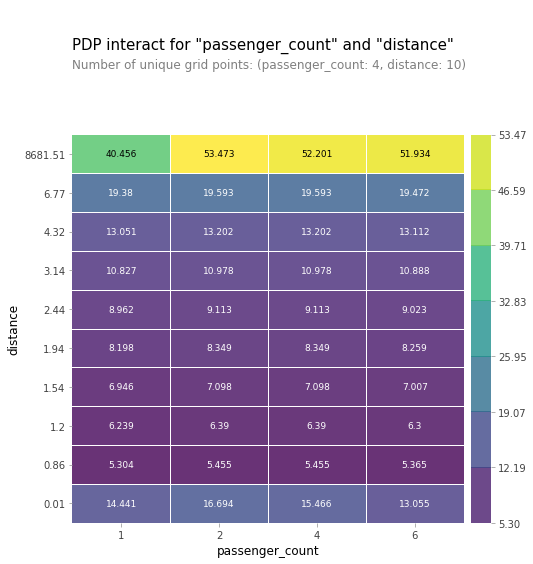

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['passenger_count','distance']

interaction = pdp_interact(
    model=boosting, 
    dataset=X_val_encoded,
    model_features=X_val.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

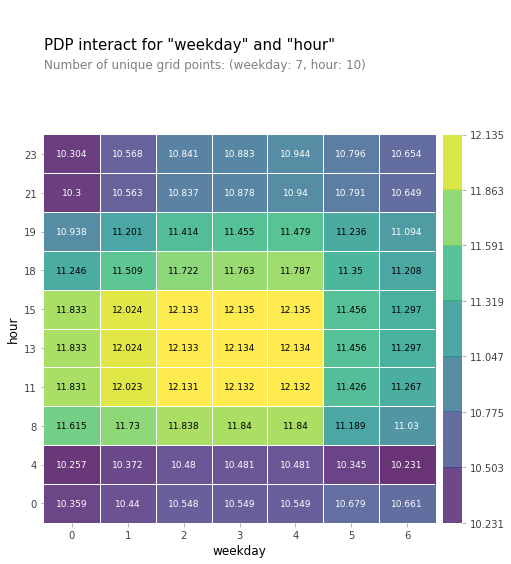

In [ ]:
features = ['weekday','hour']

interaction = pdp_interact(
    model=boosting, 
    dataset=X_val_encoded,
    model_features=X_val.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

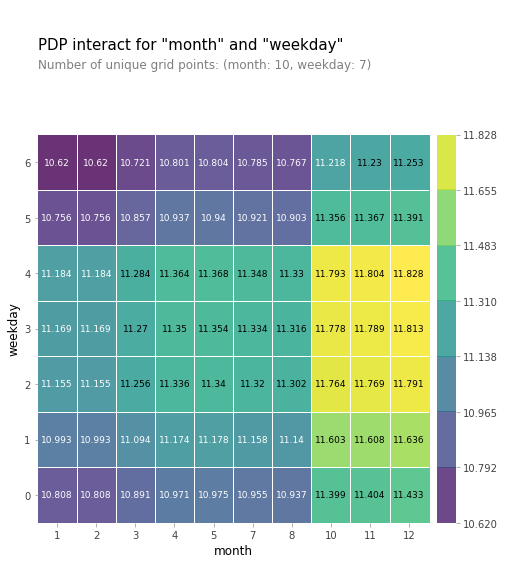

In [ ]:
features = ['month','weekday']

interaction = pdp_interact(
    model=boosting, 
    dataset=X_val_encoded,
    model_features=X_val.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

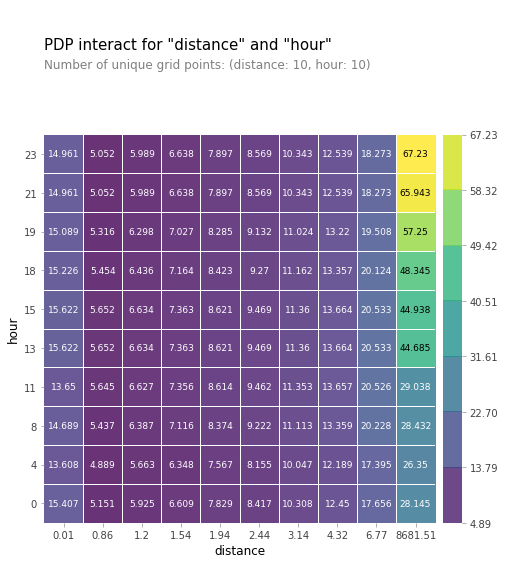

In [ ]:
features = ['distance','hour']

interaction = pdp_interact(
    model=boosting, 
    dataset=X_val_encoded,
    model_features=X_val.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [ ]:
import shap

explainer = shap.TreeExplainer(boosting)
shap_values = explainer.shap_values(X_test)

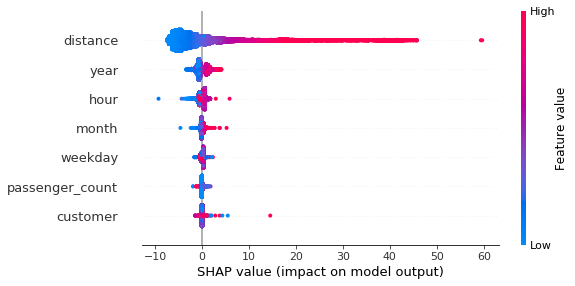

In [ ]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

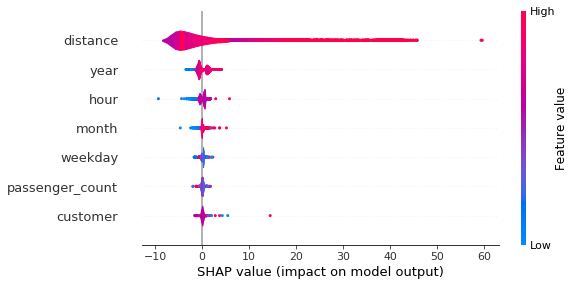

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="violin")

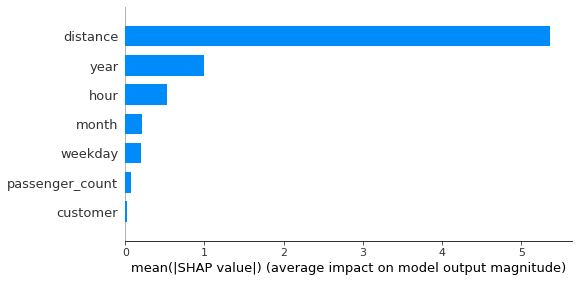

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
row = X_test.iloc[[1]] 
row

,customer,passenger_count,year,month,weekday,hour,distance
150893,15677036,1,2010,6,3,6,1.31


In [ ]:
y_test.iloc[[1]]

150893    6.5
Name: fare_amount, dtype: float64

In [ ]:
import shap

explainer = shap.TreeExplainer(boosting)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

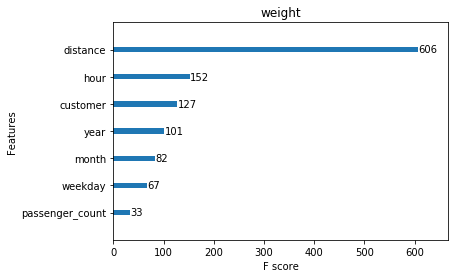

In [ ]:
from xgboost import plot_importance
plot_importance(boosting, importance_type='weight',grid=False, title='weight'); # 해당 feature가 노드 분기에 사용된 횟수

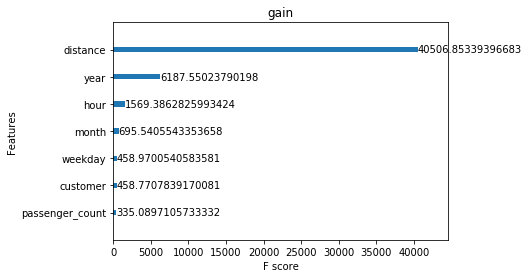

In [ ]:
plot_importance(boosting, importance_type='gain',grid=False, title='gain'); # 해당 feature가 모델 예측에 어느정도 영향을 미쳤는가, feature가 사용된 전체 노드의 평균 gain